In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2 as cv
import pickle
import io
import os
import glob
%matplotlib inline

In [2]:
images_store = glob.glob('camera_cal/calibration*.jpg')

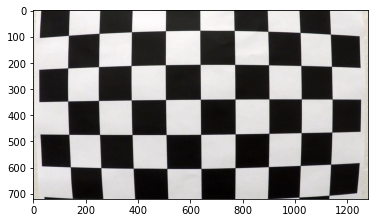

In [3]:
img = mpimg.imread(images_store[0])
plt.imshow(img)

In [4]:
# storing coordinates of chessboard and storing points of image
points_in_chess = []
points_in_images = []

# make an points for objects and location of interest in the chessboard
ax_x = 9
ax_y = 6
obj_points = np.zeros((ax_x*ax_y, 3), np.float32)
obj_points[:,:2] = np.mgrid[0:ax_x, 0:ax_y].T.reshape(-1, 2)

for image in images_store:
    img = mpimg.imread(image)
    # make an grayscale image
    grayscale = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    success, corners = cv.findChessboardCorners(grayscale, (ax_x, ax_y), None)
    if success:
        points_in_images.append(corners)
        points_in_chess.append(obj_points)
    else:
        print('corners not found {}'.format(image))

corners not found camera_cal\calibration1.jpg
corners not found camera_cal\calibration4.jpg
corners not found camera_cal\calibration5.jpg


<Figure size 432x288 with 0 Axes>

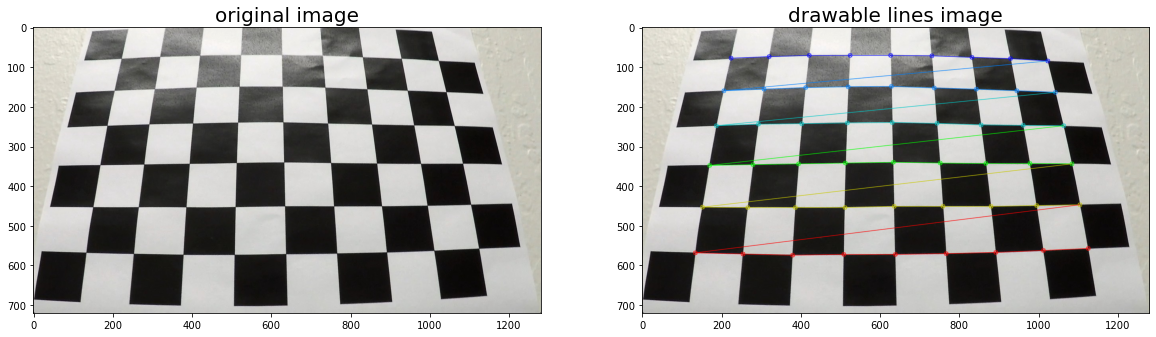

In [5]:
# plotting original image and drawable lines image
img = mpimg.imread('camera_cal/calibration3.jpg')
plt.figure()
figure, (s1, s2) = plt.subplots(1, 2, figsize=(20,20))
s1.imshow(img)
s1.set_title('original image', fontsize=20)
grayscale = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # Find corners of chessboard, (we had to grayscale first to find them)
retrn,corners = cv.findChessboardCorners(grayscale, (ax_x, ax_y), None)
if retrn == False:
    print('outside corner not found')
    # draw the corner in the image
img_2 = cv.drawChessboardCorners(img, (ax_x, ax_y), corners, retrn)
s2.imshow(img_2)
s2.set_title('drawable lines image', fontsize=20)
plt.show
plt.savefig('saved_figures/chess_corners.png')

In [6]:
points_of_pkl = {}
points_of_pkl["chess_points"] = points_in_chess
points_of_pkl["image_points"] = points_in_images
points_of_pkl["image_size"] = (img.shape[1], img.shape[0])

In [7]:
# distortion correction
pickle.dump(points_of_pkl,open("image_with_object_points.pkl", "wb" ))

In [8]:
points_with_pickle = pickle.load(open("image_with_object_points.pkl","rb" ))

In [9]:
points_in_chess = points_with_pickle["chess_points"]
points_in_images = points_with_pickle["image_points"]
img_size = points_with_pickle["image_size"]
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(
    points_in_chess,
    points_in_images,
    img_size, None, None)

In [10]:
dash_cam = {}
dash_cam['dist'] = dist
dash_cam['mtx'] = mtx
dash_cam['image_size'] = img_size
pickle.dump(dash_cam,open('matrix_of_camera.pkl', 'wb'))

In [11]:
def distortion_correct(img,mtx,dist,img_size_of_camera):
    img_1 = (img.shape[1], img.shape[0])
    assert(img_1==img_size_of_camera)
    undistorted = cv.undistort(img,mtx,dist,None,mtx)
    return undistorted

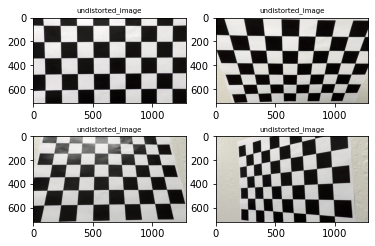

In [12]:
#trying distortion correctnes in chess images
for collection in range(4):
    img = mpimg.imread('camera_cal/calibration' + str(collection+1)+ '.jpg')
    undst = distortion_correct(img,mtx,dist,img_size)
    plt.subplot(2,2, collection+1)
    plt.imshow(undst)
    plt.title('undistorted_image', fontsize=7)
plt.savefig('saved_figures/undistorted_chess.png')

In [13]:
# load camera and distortion matrix
dash_cam = pickle.load(open('matrix_of_camera.pkl', 'rb'))
mtx, dist, img_size_of_camera = dash_cam['mtx'], dash_cam['dist'], dash_cam['image_size']

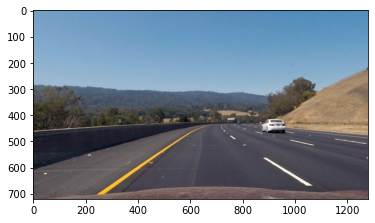

In [14]:
# plotting undistorted to image of dash cam
image = mpimg.imread('test_images/test3.jpg')
image = distortion_correct(image,mtx,dist,img_size_of_camera)
plt.imshow(image)

In [15]:
# creating canny edge detection to contain sobel gradients
def thresh_sobel_mov(img, movement='x_axis', thresh=(0,255)):
    grayscale = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    if movement == 'x_axis':
        mov_sobel = np.absolute(
            cv.Sobel(grayscale, cv.CV_64F, 1,0))
    if movement == 'y_axis':
        mov_sobel = np.absolute(
            cv.Sobel(grayscale, cv.CV_64F, 0,1))
    scaled_of_sobel = np.uint8(255 * mov_sobel/ np.max(mov_sobel))
    output_of_binary = np.zeros_like(scaled_of_sobel)
    output_logs = scaled_of_sobel>=thresh[0]
    output_logs_2 = scaled_of_sobel<=thresh[1]
    output_of_binary[(output_logs)&(output_logs_2)] = 1
    return output_of_binary

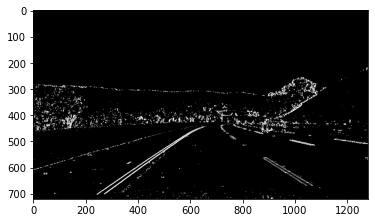

In [16]:
# plotting canny edge detection along with sobel
plt.imshow(thresh_sobel_mov(image, thresh=(20, 100)), cmap='gray')

In [17]:
# creating gradient magnitude function
def magnitude_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    grayscale = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    x_axis = cv.Sobel(grayscale, cv.CV_64F, 1,0, ksize=sobel_kernel)
    y_axis = cv.Sobel(grayscale, cv.CV_64F, 0,1, ksize=sobel_kernel)
    magnitude = np.sqrt(x_axis**2+y_axis**2)
    scale_all = np.max(magnitude)/255
    bit_eig = (magnitude/scale_all).astype(np.uint8)
    output_of_binary = np.zeros_like(bit_eig)
    output_logs_bit8_1 = bit_eig>thresh[0]
    output_logs_bit8_2 = bit_eig<thresh[1]
    output_of_binary[(output_logs_bit8_1)&(output_logs_bit8_2)] = 1
    return output_of_binary

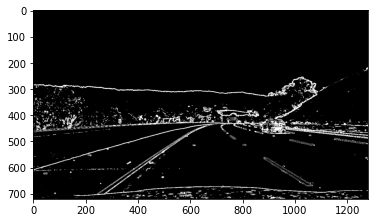

In [18]:
plt.imshow(magnitude_threshold(image, thresh=(20,100)),  cmap='gray')

In [19]:
# creating gradient direction
# the purpose is to filter direction of the gradient
def dir_threshold(img, sobel_kernel=5, thresh=(0, np.pi/2)):
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    x = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel))
    y = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel)) 
    direction = np.arctan2(y, x)
    output_of_binary = np.zeros_like(direction)
    output_dir = direction>thresh[0]
    output_dir_2 = direction<thresh[1]
    output_of_binary[(output_dir)&(output_dir_2)] = 1
    return output_of_binary

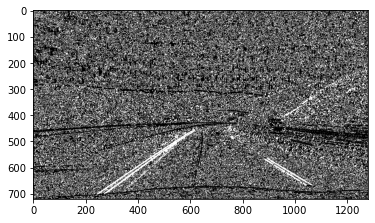

In [20]:
plt.imshow(dir_threshold(image, thresh=(0.6,1.2)),  cmap='gray')

In [21]:
# creating hue saturation lightness color to retain image information based on gradient filters
def hls_select(img, sthresh=(0, 255),lthresh=()):
    hsl_image = cv.cvtColor(img, cv.COLOR_RGB2HLS)
    L_channel = hsl_image[:,:,1]
    S_channel = hsl_image[:,:,2]
    output_of_binary = np.zeros_like(S_channel)
    output_s = S_channel >= sthresh[0]
    output_s_2 = S_channel<=sthresh[1]
    output_L = L_channel>lthresh[0]
    output_L_2 = L_channel <= lthresh[1]
    output_of_binary[(output_s) & (output_s_2) & (output_L) & (output_L_2)] = 1
    return output_of_binary

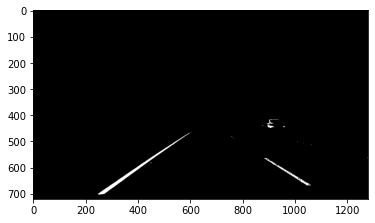

In [22]:
# plotting hue saturation channel
plt.imshow(hls_select(image, sthresh=(140,255), lthresh=(120, 255)),  cmap='gray')

In [23]:
def red_select(img, thresh=(0, 255)):
    Red_channel = img[:,:,0]
    output_of_binary = np.zeros_like(Red_channel)
    red_channel_output = Red_channel>thresh[0]
    red_channel_output_2 = Red_channel<=thresh[1]
    output_of_binary[(red_channel_output) & (red_channel_output_2)] = 1
    return output_of_binary

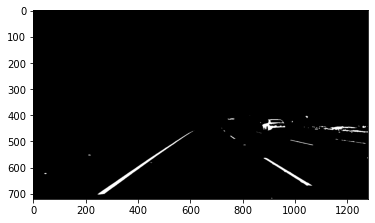

In [24]:
plt.imshow(red_select(image, thresh=(200,255)),  cmap='gray')

In [25]:
# combining all filter to get refined binary images
def pipeline_of_binary(img):
    img_copy = cv.GaussianBlur(img, (3, 3), 0)
    img_copy = np.copy(img)
    # color channels
    binary_of_saturation = hls_select(img_copy, sthresh=(140, 255), lthresh=(120, 255))
    binary_of_red = red_select(img_copy, thresh=(200,255))
    # Sobel gradient
    binary_of_x = thresh_sobel_mov(img_copy,thresh=(25, 200))
    binary_of_y = thresh_sobel_mov(img_copy,thresh=(25, 200), movement='y_axis')
    xy = cv.bitwise_and(binary_of_x,binary_of_y)
    #magnitude & direction
    binary_of_magnitude = magnitude_threshold(img_copy, sobel_kernel=5, thresh=(30,100))
    binary_of_dir = dir_threshold(img_copy, sobel_kernel=5, thresh=(0.8, 1.2))
    # Stack each channel
    gradient_stack = np.zeros_like(binary_of_saturation)
    gradient_stack[
        ((binary_of_x == 1) & (binary_of_y == 1)) | ((binary_of_magnitude == 1) & (binary_of_magnitude== 1))
        ] = 1
    final_binary_result = cv.bitwise_or(binary_of_saturation, gradient_stack)
    return final_binary_result

<Figure size 432x288 with 0 Axes>

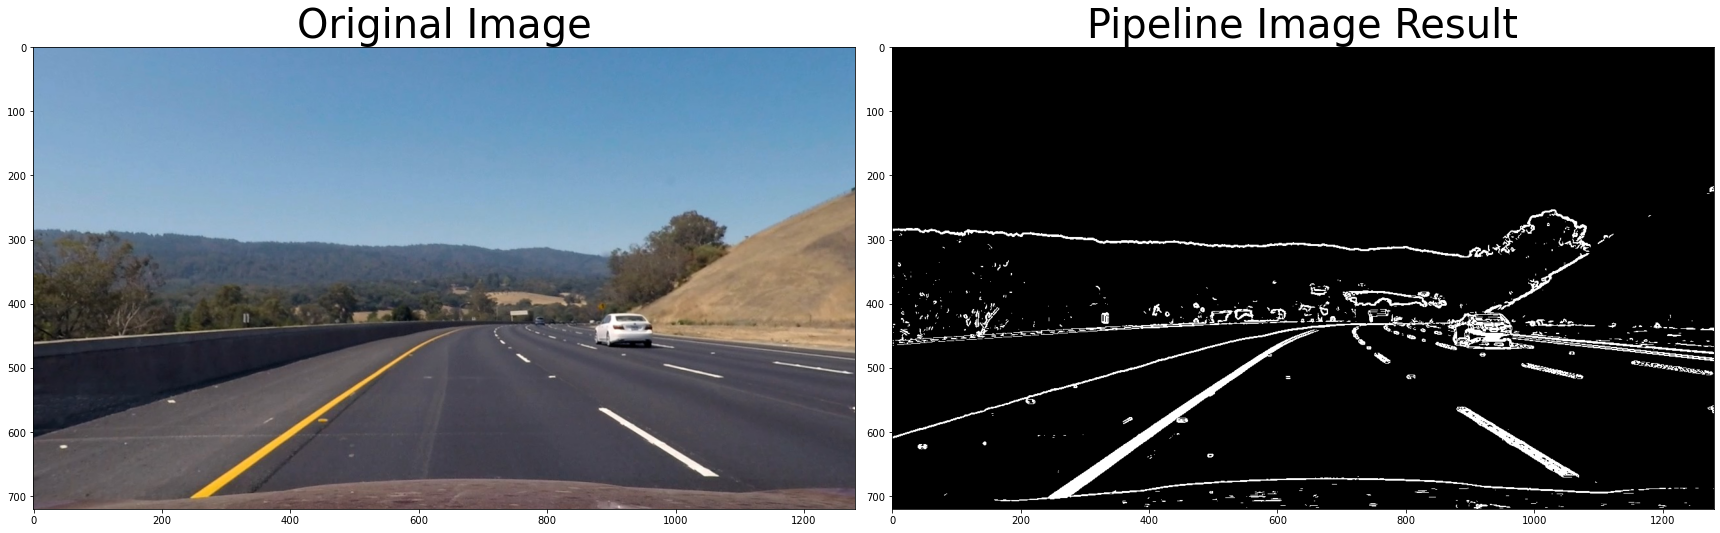

In [26]:
# plotting the result based on combining function before
res = pipeline_of_binary(image)
plt.figure()
figure, (original, pipeline) = plt.subplots(1, 2, figsize=(24, 8))
figure.tight_layout()
original.imshow(image)
original.set_title('Original Image', fontsize=40)
pipeline.imshow(res,cmap='gray')
pipeline.set_title('Pipeline Image Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()
plt.savefig('saved_figures/combined_filters.png')

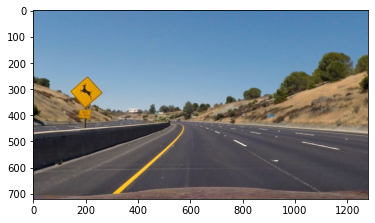

In [27]:
# trying undistorted into dashcam image
image=mpimg.imread('test_images/test2.jpg')
image = distortion_correct(image, mtx, dist, img_size_of_camera)
plt.imshow(image)

<Figure size 432x288 with 0 Axes>

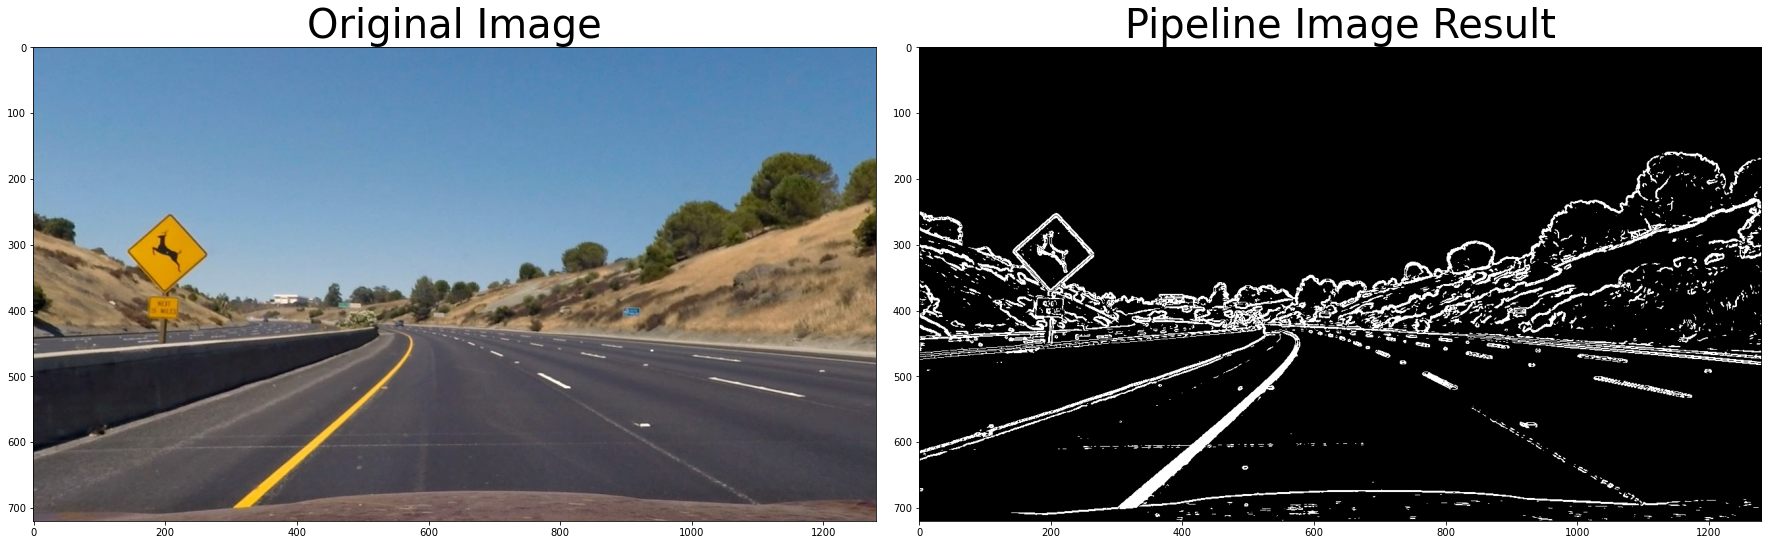

In [28]:
# plotting the result
res = pipeline_of_binary(image)
plt.figure()
figure, (original, pipeline) = plt.subplots(1, 2, figsize=(24, 8))
figure.tight_layout()
original.imshow(image)
original.set_title('Original Image', fontsize=40)
pipeline.imshow(res,cmap='gray')
pipeline.set_title('Pipeline Image Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [31]:
# this is are making perspective transform
def warp_image(img):
    
    image_size = (img.shape[1], img.shape[0])
    x = img.shape[1]
    y = img.shape[0]
    source_points = np.float32([
    [0.117 * x, y], [(0.5 * x) - (x*0.078), (2/3)*y],
    [(0.5 * x) + (x*0.078), (2/3)*y],
    [x - (0.117 * x), y]
    ]) 
    destination_points = np.float32([
    [0.25 * x, y], [0.25 * x, 0],
    [x - (0.25 * x), 0], [x - (0.25 * x), y]
    ])
    
    perspective_transform = cv.getPerspectiveTransform(source_points, destination_points)
    inverse_perspective_transform = cv.getPerspectiveTransform( destination_points, source_points)
    
    warped_img = cv.warpPerspective(img, perspective_transform, image_size, flags=cv.INTER_LINEAR)
    return warped_img, inverse_perspective_transform

<Figure size 432x288 with 0 Axes>

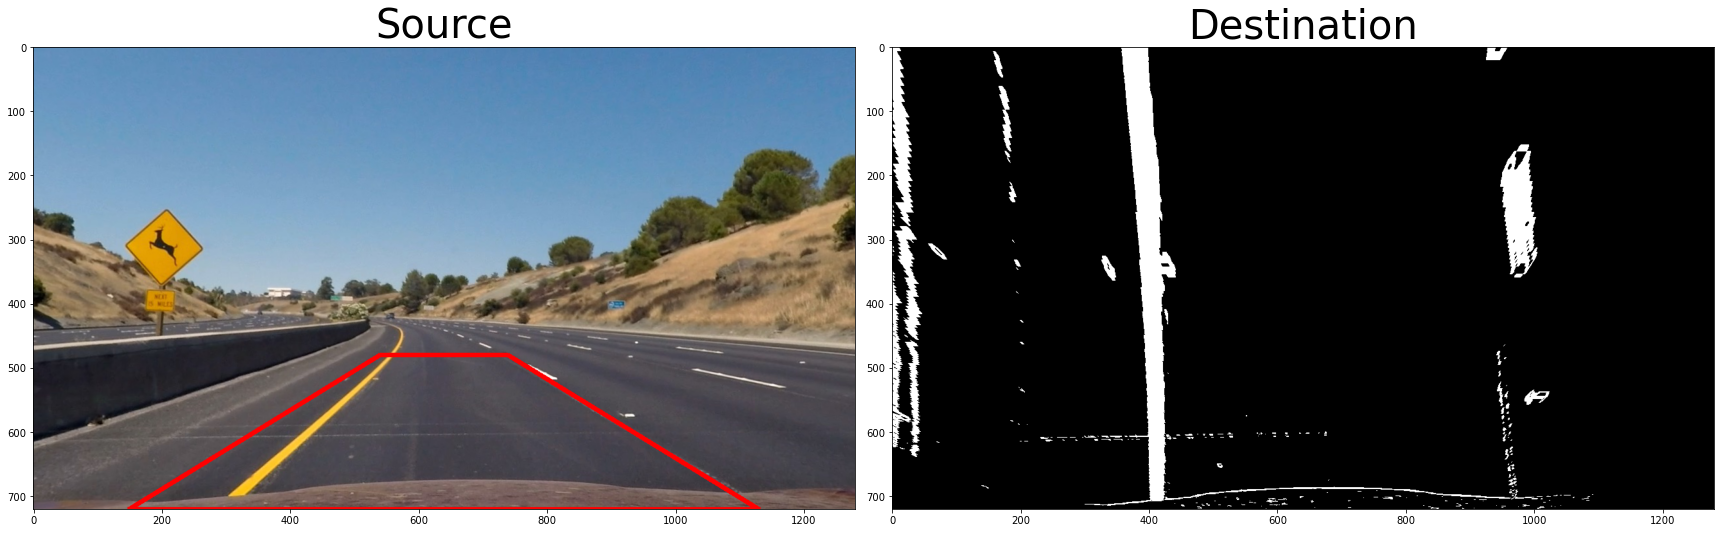

In [32]:
birdseye_result, inverse_perspective_transform = warp_image(res)
# Plot the result
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


image_size = (image.shape[1], image.shape[0])
x = image.shape[1]
y = image.shape[0]
source_points = np.int32([
                    [0.117 * x, y],
                    [(0.5 * x) - (x*0.078), (2/3)*y],
                    [(0.5 * x) + (x*0.078), (2/3)*y],
                    [x - (0.117 * x), y]
                    ])

draw_poly = cv.polylines(image,[source_points],True,(255,0,0), 5)

ax1.imshow(draw_poly)
ax1.set_title('Source', fontsize=40)
ax2.imshow(birdseye_result, cmap='gray')
ax2.set_title('Destination', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()
plt.savefig('saved_figures/perspective_transform.png')

In [35]:
# reload the image for later use
image = mpimg.imread('test_images/test5.jpg')
image = distortion_correct(image,mtx,dist,img_size_of_camera)

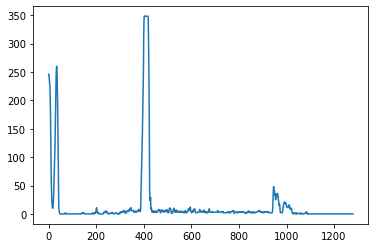

In [36]:
# making histogram to look the distribution in image
histogram = np.sum(birdseye_result[int(birdseye_result.shape[0]/2):,:], axis=0)
plt.figure()
plt.plot(histogram)
plt.savefig('saved_figures/lane_histogram.png')

In [37]:
def track_lanes_initialize(binary_warped):
    global window_search
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # we need max for each half of the histogram. the example above shows how
    # things could be complicated if didn't split the image in half 
    # before taking the top 2 maxes
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    # this will throw an error in the height if it doesn't evenly divide the img height
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
        win_y_high = int(binary_warped.shape[0] - window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit

In [38]:
left_fit,right_fit = track_lanes_initialize(birdseye_result)

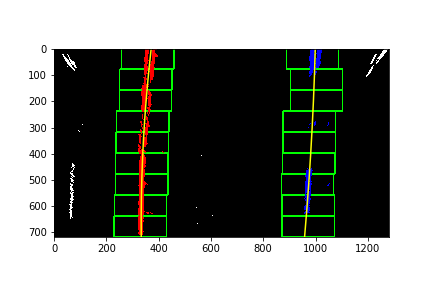

In [39]:
# the result from track lane lines function
Image('saved_figures/01_window_search.png')

In [40]:
# this function works as make polynomial and looking pixel margin for non-zero pixels
def track_lanes_update(binary_warped, left_fit,right_fit):
    global window_search
    global frame_count   
    # repeat window search to maintain stability
    if frame_count % 10 == 0:
        window_search=True           
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit,right_fit,leftx,lefty,rightx,righty

In [41]:
global frame_count
frame_count=0
left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye_result, left_fit,right_fit)

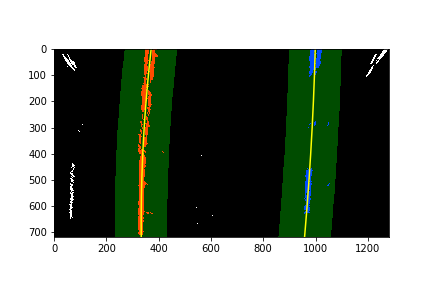

In [42]:
Image('saved_figures/02_updated_search_window.png')

In [43]:
# A function to get quadratic polynomial output
def get_val(y,poly_coeff):
    return poly_coeff[0]*y**2+poly_coeff[1]*y+poly_coeff[2]

In [44]:
def lane_fill_poly(binary_warped,undist,left_fit,right_fit):
    # Generate x and y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = get_val(ploty,left_fit)
    right_fitx = get_val(ploty,right_fit)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast x and y for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane 
    cv.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp using inverse perspective transform
    newwarp = cv.warpPerspective(color_warp, inverse_perspective_transform, (binary_warped.shape[1], binary_warped.shape[0])) 
    # overlay
    #newwarp = cv.cvtColor(newwarp, cv.COLOR_BGR2RGB)
    result = cv.addWeighted(undist, 1, newwarp, 0.3, 0)        
    return result

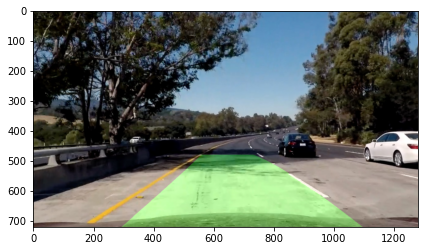

In [45]:
colored_lane = lane_fill_poly(birdseye_result, image, left_fit, right_fit)
plt.figure()
plt.imshow(colored_lane)
plt.tight_layout()
plt.savefig('saved_figures/lane_polygon.png')

In [46]:
def measure_curve(binary_warped,left_fit,right_fit):
        
    # generate y values 
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # measure radius at the maximum y value, or bottom of the image
    # this is closest to the car 
    y_eval = np.max(ploty)
    
    # coversion rates for pixels to metric
    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    # x positions lanes
    leftx = get_val(ploty,left_fit)
    rightx = get_val(ploty,right_fit)

    # fit polynomials in metric 
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # calculate radii in metric from radius of curvature formula
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # averaged radius of curvature of left and right in real world space
    # should represent approximately the center of the road
    curve_rad = round((left_curverad + right_curverad)/2)
    
    return curve_rad

In [47]:
measure_curve(birdseye_result,left_fit, right_fit)

1908

In [48]:
def vehicle_offset(img,left_fit,right_fit):
    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    xm_per_pix = 3.7/700 
    image_center = img.shape[1]/2
    ## find where lines hit the bottom of the image, closest to the car
    left_low = get_val(img.shape[0],left_fit)
    right_low = get_val(img.shape[0],right_fit)
    # pixel coordinate for center of lane
    lane_center = (left_low+right_low)/2.0
    ## vehicle offset
    distance = image_center - lane_center
    ## convert to metric
    return (round(distance*xm_per_pix,5))

In [49]:
offset = vehicle_offset(colored_lane, left_fit, right_fit)
print(offset)

-0.19122


In [64]:
def img_pipeline(img):
    global window_search
    global left_fit_prev
    global right_fit_prev
    global frame_count
    global curve_radius
    global offset
        
    # load camera matrix and distortion matrix
    camera = pickle.load(open( "matrix_of_camera.pkl", "rb" ))
    mtx = camera['mtx']
    dist = camera['dist']
    camera_img_size = camera['image_size']
    
    #correct lens distortion
    undist = distortion_correct(img,mtx,dist,img_size_of_camera)
    # get binary image
    binary_img = pipeline_of_binary(undist)
    #perspective transform
    birdseye, inverse_perspective_transform = warp_image(binary_img)
    
    if window_search:
        #window_search = False
        #window search
        left_fit,right_fit = track_lanes_initialize(birdseye)
        #store values
        left_fit_prev = left_fit
        right_fit_prev = right_fit
        
    else:
        #load values
        left_fit = left_fit_prev
        right_fit = right_fit_prev
        #search in margin of polynomials
        left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye, left_fit,right_fit)
    
    #save values
    left_fit_prev = left_fit
    right_fit_prev = right_fit
    
    #draw polygon
    processed_frame = lane_fill_poly(birdseye, undist, left_fit, right_fit)
    
    #update ~twice per second
    if frame_count==0 or frame_count%15==0:
        #measure radii
        curve_radius = measure_curve(birdseye,left_fit,right_fit)
        #measure offset
        offset = vehicle_offset(undist, left_fit, right_fit)
    
        
    #printing information to frame
    font = cv.FONT_HERSHEY_TRIPLEX
    processed_frame = cv.putText(processed_frame, 'Radius: '+str(curve_radius)+' m', (30, 40), font, 1, (0,255,0), 2)
    processed_frame = cv.putText(processed_frame, 'Offset: '+str(offset)+' m', (30, 80), font, 1, (0,255,0), 2)
   
    frame_count += 1
    return processed_frame

In [65]:
filenames = os.listdir("test_images/")
global window_search
global frame_count
for filename in filenames:
    frame_count = 15
    window_search = True
    image = mpimg.imread('test_images/'+filename)
    lane_image = img_pipeline(image)
    mpimg.imsave('output_images/lane_'+filename,lane_image)

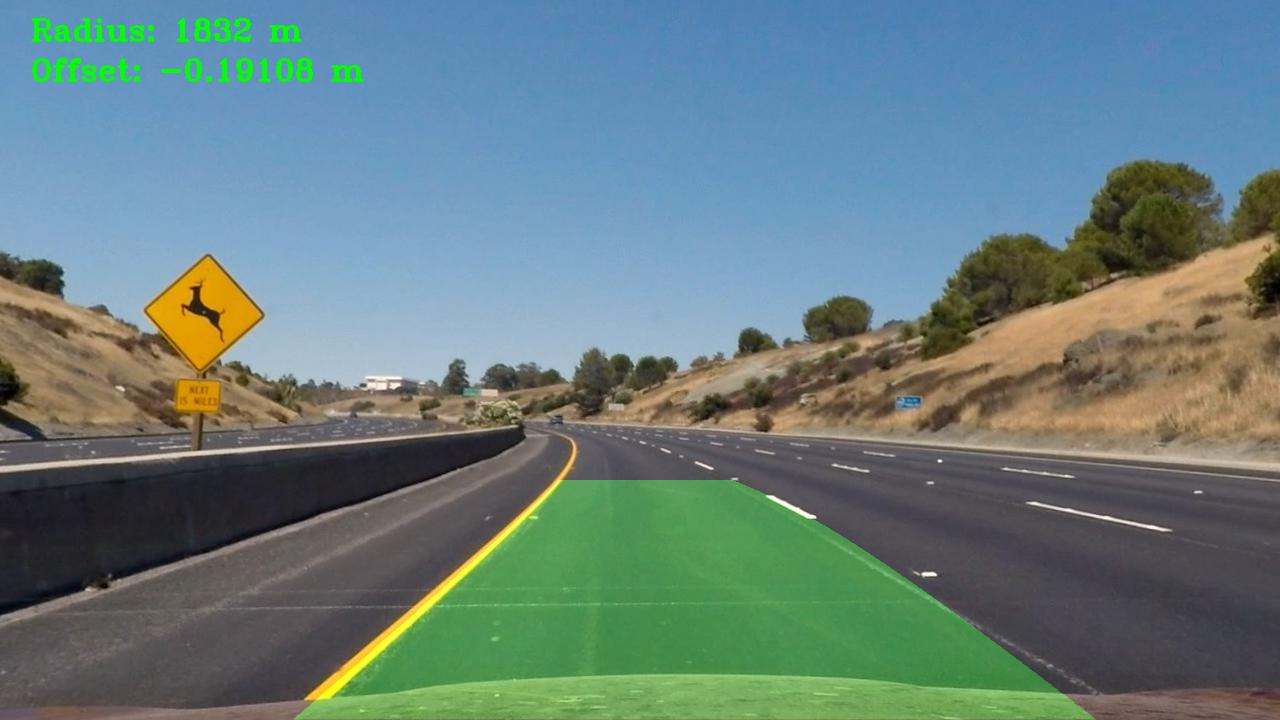

In [66]:
Image('output_images/lane_test2.jpg')

In [67]:
from moviepy.video.fx.all import crop

In [70]:
global window_search 
global frame_count
window_search = True
frame_count = 0

#chicago footage
for filename in ['chicago_lanelines.mp4']:
    clip = VideoFileClip('videos/'+filename)#.subclip((3,25),(3,35))
    #clip_crop = crop(clip, x1=320, y1=0, x2=1600, y2=720)
    out= clip.fl_image(img_pipeline)
    #out = clip_crop.fl_image(img_pipeline)
    out.write_videofile('videos/processed_'+filename, audio=False, verbose=False)
    print('Success!')

Moviepy - Building video videos/processed_chicago_lanelines.mp4.
Moviepy - Writing video videos/processed_chicago_lanelines.mp4



Moviepy - Done !
Moviepy - video ready videos/processed_chicago_lanelines.mp4
Success!


In [71]:
video = 'videos/processed_project_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video))